In [1]:
# Preparation:
# > sudo pip3 install ffmpeg-python
# > sudo pip3 install numpy

import ffmpeg
import cv2
import os
import subprocess
import numpy
import darknet
import re
import time
from darknet_tools import *
from ffmpeg_tools import *
import sys
from sklearn.metrics import roc_auc_score
from argparse import ArgumentParser

def time_str_to_seconds(time_str):
    return sum(int(x) * (60 ** i) for i, x in enumerate(reversed(time_str.split(':'))))

def start_ffmpeg_process(filename):
    args = (
        ffmpeg
            .input(filename)
            .output('pipe:', format='rawvideo', pix_fmt='bgr24')
            .compile()
    )
    return subprocess.Popen(args, stdout=subprocess.PIPE)

def read_frame(process, width, height):
    frame_size = width * height * 3
    bytes = process.stdout.read(frame_size)
    if len(bytes) != frame_size:
        return None
    else:
        frame = (
            numpy
            .frombuffer(bytes, numpy.uint8)
            .reshape([height, width, 3])
        )
        return frame

# video_filename = 'rtsp://wowzaec2demo.streamlock.net/vod/mp4:BigBuckBunny_115k.mov'
if len(sys.argv) < 2:
    print('Usage:\r\npython3.6 analyze_service.py "path/to/video.flv" [--show]')
    exit(0)

video_filename = sys.argv[1]# os.path.join('cut_videos', 'Ватутина ул - 2-я Северная ул. с Мой Дом [12.03.2021] 10_18-10_20.flv')
if len(sys.argv) == 3:
    show = sys.argv[2] == '--show'
else:
    show = False
# video_filename = os.path.join('cut_videos', 'Шотмана ул. - Ленина пр. с Мой Дом [12.03.2021] 10_22-10_24.flv')

video_filename='11.flv'

has_timings = False
timings_filename = video_filename + '.txt'
if os.path.exists(timings_filename):
    has_timings = True
    with open(timings_filename, 'r') as timings:
        time_visible, time_distinguishable, time_indistinguishable, time_invisible =\
            timings.readlines()[0].strip().split('-')
        seconds_visible = time_str_to_seconds(time_visible)
        seconds_distinguishable = time_str_to_seconds(time_distinguishable)
        seconds_indistinguishable = time_str_to_seconds(time_indistinguishable)
        seconds_invisible = time_str_to_seconds(time_invisible)

probe = ffmpeg.probe(video_filename)
print(probe)
for stream in probe['streams']:
    if stream['codec_type'] == 'video':
        stream_parameters = stream
width, height = stream_parameters['width'], stream_parameters['height']
avg_frame_rate = eval(stream_parameters['avg_frame_rate'])

POSTFIX = '-tiny-fox'
prepare_darknet_config('yolov4' + POSTFIX + '.cfg', 'yolov4' + POSTFIX + '-temp.cfg', width, height)
network, class_names, class_colors = darknet.load_network(
        'yolov4' + POSTFIX + '-temp.cfg',
        os.path.join('data', 'fox.data'),
        'yolov4' + POSTFIX + '_final.weights',
        1
    )

out = cv2.VideoWriter(video_filename + '_result.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), avg_frame_rate,
                      (width, height))
results = open(video_filename + '_result.txt', 'w')
process = start_ffmpeg_process(video_filename)
frame_index = 0
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
precision = 'N/A'
recall = 'N/A'
f1 = 'N/A'
roc_auc = 'N/A'
y_true = []
y_score = []


old_x=0
old_y=0
old_poz=[]
while True:
    frame = read_frame(process, width, height)
    if frame is None:
        break
    frame_index += 1
    # if frame_index < 500:
    #     continue

    current_second = frame_index / avg_frame_rate

    begin_time = time.time()
    detections = image_detection(frame, network, class_names, 0.35)
    end_time = time.time()
    delay = round((end_time - begin_time) * 100.0) / 100.0

    # print(detections)
    has_detection = False
    for d in detections:
        probability = d[1]

        
        
        x, y, w, h = d[2]
        x1 = int(x - w / 2.0)
        y1 = int(y - h / 2.0)
        x2 = int(x + w / 2.0)
        y2 = int(y + h / 2.0)
        if d[0] == 'car':
            color = (0, 0, 255)
            text_shift = 4
        else:
            color = (0, 255, 255)
            text_shift = 28
        #########################  
        if d[0] == 'car':
            old_poz.append((int(x),int(y)))
            try:
                cv2.line(frame, (int(x), int(y)), old_poz[-2], color, 2)
            except Exception as e:
                print(e)  
        ###########################    

        
        
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, str(int(float(probability) * 100) / 100), (x1, y1 - text_shift), cv2.FONT_HERSHEY_DUPLEX,
                    0.75, color)
        has_detection = True

    if has_timings:
        if (current_second >= seconds_distinguishable + 1) and (current_second < seconds_indistinguishable):
            detecting = True
            y_true.append(1)
            if has_detection:
                y_score.append(1)
                true_positive += 1
            else:
                y_score.append(0)
                false_negative += 1
        elif (current_second < seconds_visible) or (current_second >= seconds_invisible + 1):
            detecting = True
            y_true.append(0)
            if has_detection:
                y_score.append(1)
                false_positive += 1
            else:
                y_score.append(0)
                true_negative += 1
        else:
            detecting = False

        if detecting:
            color = (0, 255, 0)
        else:
            color = (63, 63, 63)
        cv2.rectangle(frame, (0, 0), (width, height), color, 4)
        cv2.circle(frame, (width - 12, 12), 8, color, -1)

        try:
            precision = true_positive / (true_positive + false_positive)
            precision = int(precision * 100) / 100
        except:
            precision = 'N/A'
        try:
            recall = true_positive / (true_positive + false_negative)
            recall = int(recall * 100) / 100
        except:
            recall = 'N/A'
        try:
            f1 = 2 * precision * recall / (precision + recall)
            f1 = int(f1 * 100) / 100
        except:
            f1 = 'N/A'

        try:
            roc_auc = roc_auc_score(y_true, y_score)
            roc_auc = int(roc_auc * 100) / 100
        except:
            roc_auc = 'N/A'

        cv2.putText(frame, 'TP: ' + str(true_positive), (8, 32), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'TN: ' + str(true_negative), (8, 48), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'FP: ' + str(false_positive), (8, 64), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'FN: ' + str(false_negative), (8, 80), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'Precision: ' + str(precision), (8, 96), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'Recall: ' + str(recall), (8, 112), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'F1: ' + str(f1), (8, 128), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'ROC AUC: ' + str(roc_auc), (8, 144), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
        cv2.putText(frame, 'Current second: ' + str(current_second), (8, 160), cv2.FONT_HERSHEY_DUPLEX, 0.5,
                    (0, 255, 0))

    cv2.putText(frame, 'Delay, sec.: ' + str(delay), (8, 16), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0))
    if show:
        cv2.imshow('frame', frame)
        cv2.waitKey(1)

    out.write(frame)

    print('Frame: ' + str(frame_index) + ', Delay, sec.: ' + str(delay) + ', TP: ' + str(true_positive) +
          ', TN: ' + str(true_negative) + ', FP: ' + str(false_positive) + ', FN: ' + str(false_negative) +
          ', Precision: ' + str(precision) + ', Recall: ' + str(recall) + ', F1: ' + str(f1) +
          ', ROC AUC: ' + str(roc_auc))
    results.write(str(frame_index) + ',' + str(1 if has_detection else 0) + ',' + str(delay) + '\r\n')

out.release()


{'streams': [{'index': 0, 'codec_name': 'flv1', 'codec_long_name': 'FLV / Sorenson Spark / Sorenson H.263 (Flash Video)', 'codec_type': 'video', 'codec_time_base': '1/25', 'codec_tag_string': '[0][0][0][0]', 'codec_tag': '0x0000', 'width': 1280, 'height': 720, 'coded_width': 1280, 'coded_height': 720, 'has_b_frames': 0, 'sample_aspect_ratio': '0:1', 'display_aspect_ratio': '0:1', 'pix_fmt': 'yuv420p', 'level': -99, 'refs': 1, 'r_frame_rate': '25/1', 'avg_frame_rate': '25/1', 'time_base': '1/1000', 'start_pts': 0, 'start_time': '0.000000', 'bit_rate': '200000', 'disposition': {'default': 0, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impaired': 0, 'clean_effects': 0, 'attached_pic': 0, 'timed_thumbnails': 0}}], 'format': {'filename': '11.flv', 'nb_streams': 1, 'nb_programs': 0, 'format_name': 'flv', 'format_long_name': 'FLV (Flash Video)', 'start_time': '0.000000', 'duration': '10.000000', 'size': '1042728', 'bit_rate': '

Frame: 71, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 72, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 73, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 74, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 75, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 76, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 77, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 78, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 79, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 80, Delay, s

Frame: 148, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 149, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 150, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 151, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 152, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 153, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 154, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 155, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 156, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 157

Frame: 225, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 226, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 227, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 228, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 229, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 230, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 231, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 232, Delay, sec.: 0.02, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 233, Delay, sec.: 0.03, TP: 0, TN: 0, FP: 0, FN: 0, Precision: N/A, Recall: N/A, F1: N/A, ROC AUC: N/A
Frame: 234

TypeError: Image data of dtype object cannot be converted to float

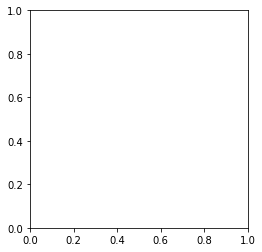

In [2]:
import matplotlib.pyplot as plt
plt.imshow(frame)
plt.show()

In [ ]:
old_poz

In [ ]:
x,y

In [ ]:
old_poz.append((x,y))

In [ ]:
old_poz

In [ ]:
old_poz[-2]